In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Load the fMRI file
fmri_file = "Preprocessed_FMRI_1.nii.gz" 
fmri_img = nib.load(fmri_file)

# Get fMRI data as a numpy array
fmri_data = fmri_img.get_fdata()  

# Print dimensions
print(f"fMRI data shape: {fmri_data.shape}") 

fMRI data shape: (73, 90, 74, 309)


In [22]:
import nibabel as nib
import numpy as np

# Load fMRI file
fmri_file = "Preprocessed_FMRI_1.nii.gz"  # Update with actual path
fmri_img = nib.load(fmri_file)

# Get fMRI data as a numpy array
fmri_data = fmri_img.get_fdata()  # Shape: (73, 90, 74, 309) -> (X, Y, Z, Time)

# Reshape to (Time, Voxels) - Flatten the 3D spatial dimensions
voxels_per_time = fmri_data.reshape(-1, fmri_data.shape[-1]).T  # Shape: (309, 486630)

# Print the new shape
print(f"Reshaped fMRI data shape: {voxels_per_time.shape}")  # Expected: (309, 486630)

Reshaped fMRI data shape: (309, 486180)


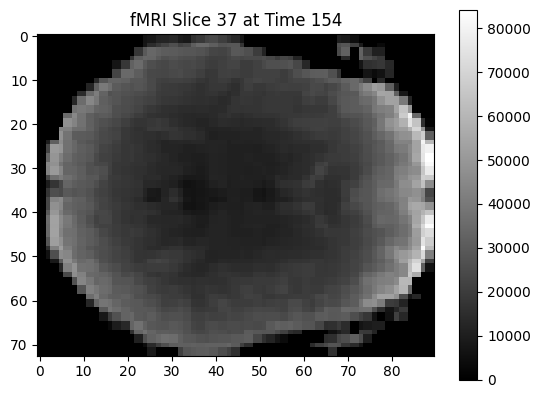

In [2]:

# Select a middle slice in Z-axis (brain slice)
z_slice = fmri_data.shape[2] // 2  # Choose mid-brain slice
t_slice = fmri_data.shape[3] // 2  # Choose middle timepoint

# Plot a middle slice at a specific timepoint
plt.imshow(fmri_data[:, :, z_slice, t_slice], cmap='gray')
plt.colorbar()
plt.title(f"fMRI Slice {z_slice} at Time {t_slice}")
plt.show()

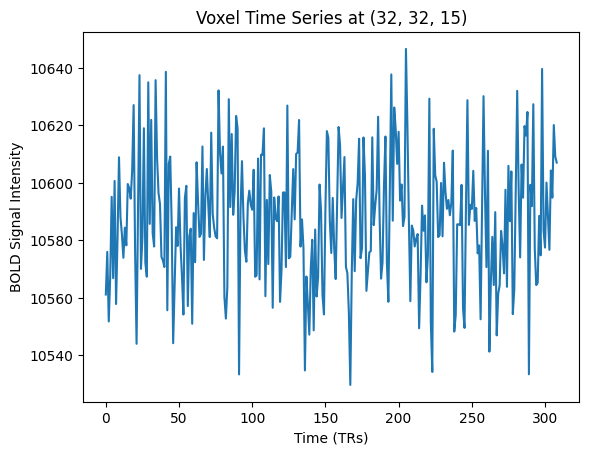

In [3]:
# Define a sample ROI (adjust coordinates for your study)
x, y, z = 32, 32, 15  # Example: select a voxel at the brain center

# Extract time series for that voxel
time_series = fmri_data[x, y, z, :]

# Plot time series
plt.plot(time_series)
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD Signal Intensity")
plt.title(f"Voxel Time Series at ({x}, {y}, {z})")
plt.show()

In [19]:
import pandas as pd
import numpy as np

prosody_df = pd.read_csv("lppFR_prosody.csv")
prosody_section1 = prosody_df.loc[prosody_df['section'] == 1].copy()  # Explicit copy

prosody_section1.loc[:, 'TR_bin'] = (prosody_section1['time'] // 2).astype(int)

prosody_aligned = prosody_section1.groupby('TR_bin')[['intensity', 'f0']].mean().reset_index()

full_tr_index = pd.DataFrame({'TR_bin': np.arange(309)})
prosody_aligned = full_tr_index.merge(prosody_aligned, on='TR_bin', how='left').ffill()

print("Shape of resampled prosody data:", prosody_aligned.shape)

prosody_aligned.head()

Shape of resampled prosody data: (309, 3)


,TR_bin,intensity,f0
0,0,0.000241,0.000000
1,1,0.109676,63.658269
2,2,0.092301,118.733616
3,3,0.135153,133.328202
4,4,0.151497,130.045771


In [15]:
import pandas as pd
import numpy as np

# Load word information CSV
word_info = pd.read_csv("lppFR_word_information.csv")  # Update with actual path

# Load prosody CSV
prosody = pd.read_csv("lppFR_prosody.csv")

# Select relevant columns
word_info = word_info[["word", "lemma", "onset", "offset", "logfreq", "pos", "section"]]

# Filter for Section 1 only
word_info = word_info[word_info["section"] == 1]

# Function to get prosody features within word onset-offset range
def extract_prosody_features(word_row, prosody_df):
    mask = (prosody_df["time"] >= word_row["onset"]) & (prosody_df["time"] <= word_row["offset"])
    subset = prosody_df[mask]
    if subset.empty:
        return pd.Series([np.nan, np.nan], index=["mean_f0", "mean_intensity"])
    return pd.Series([subset["f0"].mean(), subset["intensity"].mean()], index=["mean_f0", "mean_intensity"])

# Map prosody to words
word_info[["mean_f0", "mean_intensity"]] = word_info.apply(lambda row: extract_prosody_features(row, prosody), axis=1)

# fMRI settings
TR = 2  # fMRI time resolution in seconds
num_TRs = 309  # Total expected TRs

# Assign each word to its corresponding fMRI TR bin
word_info["fmri_TR"] = (word_info["onset"] // TR).astype(int)

# Aggregate features per TR (mean pooling)
fmri_word_features = word_info.groupby("fmri_TR").agg({
    "logfreq": "mean",
    "mean_f0": "mean",
    "mean_intensity": "mean"
}).fillna(0)

# 🔹 Ensure all 309 TRs exist (fill missing TRs with 0)
fmri_word_features = fmri_word_features.reindex(range(num_TRs), fill_value=0)

# 🔹 Add words per TR for better interpretability
word_info_grouped = word_info.groupby("fmri_TR")["word"].apply(lambda x: " ".join(x))
fmri_word_features["words"] = word_info_grouped.reindex(range(num_TRs), fill_value="")

# Print fixed shape
print(fmri_word_features.shape)  # Should now be (309, 4)
print(fmri_word_features.head())

(309, 4)
          logfreq     mean_f0  mean_intensity  \
fmri_TR                                         
0        0.000000    0.000000        0.000000   
1        0.174848  150.715921        0.163869   
2        1.767971  118.722071        0.111713   
3        2.797655   98.235765        0.108959   
4        3.021633  126.378014        0.134035   

                                       words  
fmri_TR                                       
0                                             
1                       lorsque j' avais six  
2                      ans j' ai vu une fois  
3                  une magnifique image dans  
4        un livre sur la forêt vierge qui s'  


In [16]:
fmri_word_features.head()

,logfreq,mean_f0,mean_intensity,words
fmri_TR,,,,
0,0.000000,0.000000,0.000000,
1,0.174848,150.715921,0.163869,lorsque j' avais six
2,1.767971,118.722071,0.111713,ans j' ai vu une fois
3,2.797655,98.235765,0.108959,une magnifique image dans
4,3.021633,126.378014,0.134035,un livre sur la forêt vierge qui s'
